The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2023-12-21 12:17:33 INFO  [data.backtest:22] 
{'additional_group_by': '5Min',
 'cache': False,
 'database_name': 'binance_futures',
 'depth': 112,
 'frame_width': 448,
 'futures': False,
 'group_by': '1m',
 'interval': '2d',
 'max_volume_quantile': 0.99,
 'offset_interval': '0h',
 'plot': False,
 'round_decimals': 3,
 'sequence_length': 112,
 'symbol': 'UNFIUSDT',
 'window_size': '30m'}
2023-12-21 12:17:33 DEBUG [exchange_data._database:64] SELECT last(*) AS data FROM UNFIUSDT_OrderBookFrame WHERE time >= '2023-12-19 16:25:33.008074' AND time <= '2023-12-19 16:55:33.008074' GROUP BY time(1m);
2023-12-21 12:17:33 DEBUG [exchange_data._database:64] SELECT last(*) AS data FROM UNFIUSDT_OrderBookFrame WHERE time >= '2023-12-19 16:55:33.008074' AND time <= '2023-12-19 17:25:33.008074' GROUP BY time(1m);
2023-12-21 12:17:33 DEBUG [exchange_data._database:64] SELECT last(*) AS data FROM UNFIUSDT_OrderBookFrame WHERE time >= '2023-12-19 17:25:33.008074' AND time <= '2023-12-19 17:55:33.008074'

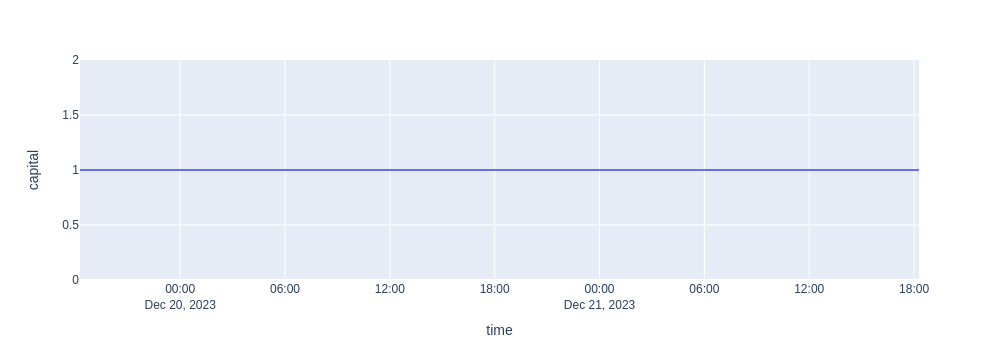

In [6]:
%load_ext autoreload
%autoreload 2

from exchange_data.data import OrderBookFrame
from exchange_data.data.backtest import Backtest
import pandas as pd
import numpy as np
import alog
import plotly.graph_objs as go
import plotly.express as px
import plotly as py
import plotly.offline as ofl
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)
params = {
 'cache': False,
 'database_name': 'binance_futures',
 'depth': 112,
 'futures': False,
 'group_by': '1m',
 'interval': '2d',
 'max_volume_quantile': 0.99,
 'offset_interval': '0h',
 'plot': False,
 'round_decimals': 3,
 'sequence_length': 112,
 'symbol': 'UNFIUSDT',
 'window_size': '30m',
 'additional_group_by': '5Min',
 'frame_width': 448
}

df = Backtest(**params).frame
capital = 1
df['capital'] = 0
df_len = df.shape[0]
capital_ls = []
price_in = 0

for ix in range(0, df_len):
    if ix < df_len - 1:
        row = df.iloc[ix]
        #next_row = df.iloc[ix + 1]
        best_ask = row['best_ask']
        best_bid = row['best_bid']
        
        if row['prediction'] == 1:
            if price_in == 0:
                price_in = best_bid
        else:
            if price_in > 0:
                pnl = (price_in - best_ask) / price_in
                alog.info((price_in, best_ask, pnl))
                capital = capital + (capital * pnl * (1 - 0.005))
                
            price_in = 0
            
    #alog.info(capital)
    capital_ls.append(capital)

df['capital'] = np.asarray(capital_ls)

df=df.loc[:, df.columns!='orderbook_img']
px.line(df, y='capital')